In [29]:
pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
# Cell 0: Force TensorFlow to use CPU only (must run BEFORE importing tensorflow)

import os

# Hide all GPUs from TensorFlow
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Optional: reduce TF log spam
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

print("✅ GPU disabled (CUDA_VISIBLE_DEVICES = -1). TensorFlow will run on CPU.")


✅ GPU disabled (CUDA_VISIBLE_DEVICES = -1). TensorFlow will run on CPU.


In [32]:
# Cell 1: Import required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("✅ All libraries imported successfully")
print("🧠 TensorFlow version:", tf.__version__)

# Confirm devices
gpus = tf.config.list_physical_devices("GPU")
cpus = tf.config.list_physical_devices("CPU")
print(f"🖥️ CPUs visible to TF: {len(cpus)}")
print(f"🎮 GPUs visible to TF: {len(gpus)}")
if len(gpus) == 0:
    print("✅ Running on CPU only.")
else:
    print("⚠️ GPU is still visible — make sure Cell 0 ran BEFORE importing TensorFlow.")


✅ All libraries imported successfully
🧠 TensorFlow version: 2.20.0
🖥️ CPUs visible to TF: 1
🎮 GPUs visible to TF: 0
✅ Running on CPU only.


In [33]:
# Cell 2: Configure LOCAL paths for LOWER BODY dataset (no S3)

LOCAL_ROOT = os.path.abspath("tight_loose_clothing_augmented/data/lower body clothing categories")  # Lower body dataset path

MODEL_DIR = os.path.abspath("models")  # Folder to save models
os.makedirs(MODEL_DIR, exist_ok=True)  # Create folder if missing

print("✅ Local configuration set:")  # Progress print
print(f"   💾 Local Dataset Path: {LOCAL_ROOT}")  # Show dataset location
print(f"   💾 Model Output Dir:   {MODEL_DIR}")  # Show model output folder

if not os.path.isdir(LOCAL_ROOT):  # Check dataset folder exists
    raise FileNotFoundError(f"❌ LOCAL_ROOT folder not found: {LOCAL_ROOT}")  # Stop if missing


✅ Local configuration set:
   💾 Local Dataset Path: /workspace/tight_loose_clothing_augmented/data/lower body clothing categories
   💾 Model Output Dir:   /workspace/models


In [34]:
# Cell 3: Verify local data and count images per category (lower body)

print("🔍 Verifying LOWER BODY dataset...\n")  # Progress print

categories = [d for d in os.listdir(LOCAL_ROOT) if os.path.isdir(os.path.join(LOCAL_ROOT, d))]  # Get subfolders as classes
categories.sort()  # Sort class names alphabetically

print(f"✅ Found {len(categories)} categories:\n")  # Print number of classes

total_images = 0  # Track total images

for idx, category in enumerate(categories, 1):  # Loop through each class folder
    category_path = os.path.join(LOCAL_ROOT, category)  # Build full path
    image_files = [  # Collect valid image files
        f for f in os.listdir(category_path)  # List files
        if os.path.isfile(os.path.join(category_path, f))  # Keep only files
        and f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"))  # Keep image extensions
    ]
    image_count = len(image_files)  # Count images
    total_images += image_count  # Add to total
    print(f"   {idx}. {category}: {image_count} images")  # Print per-class count

print(f"\n📊 Total images across all categories: {total_images}")  # Print total images

if len(categories) == 0:  # If no folders found
    raise ValueError("❌ No category folders found inside LOCAL_ROOT.")  # Stop

if total_images == 0:  # If no images found
    raise ValueError("❌ No images found. Check file extensions and folder structure.")  # Stop


🔍 Verifying LOWER BODY dataset...

✅ Found 5 categories:

   1. cargo pants: 200 images
   2. culottes: 200 images
   3. shorts: 200 images
   4. skirt: 200 images
   5. trousers: 200 images

📊 Total images across all categories: 1000


In [35]:
# Cell 4: Configure training parameters

print("⚙️ Configuring training parameters...\n")  # Progress print

IMG_SIZE = (224, 224)  # Image size for MobileNetV2
BATCH_SIZE = 32  # Batch size
EPOCHS = 300  # Max epochs

NUM_CLASSES = len(categories)  # Auto-detect classes from folders

print("📊 Training Configuration:")  # Show configuration
print(f"   Image size: {IMG_SIZE}")  # Print size
print(f"   Batch size: {BATCH_SIZE}")  # Print batch
print(f"   Max epochs: {EPOCHS}")  # Print epochs
print(f"   Number of classes: {NUM_CLASSES}")  # Print class count
print(f"   Training directory: {LOCAL_ROOT}")  # Print training path


⚙️ Configuring training parameters...

📊 Training Configuration:
   Image size: (224, 224)
   Batch size: 32
   Max epochs: 300
   Number of classes: 5
   Training directory: /workspace/tight_loose_clothing_augmented/data/lower body clothing categories


In [36]:
# Cell 5: Create data generators (train/validation split)

print("🎨 Creating data generators...\n")  # Progress print

datagen = ImageDataGenerator(  # Create data generator
    rescale=1.0 / 255.0,  # Scale pixel values to 0–1
    validation_split=0.2  # Use 20% for validation
)

train_generator = datagen.flow_from_directory(  # Training generator
    LOCAL_ROOT,  # Root folder
    target_size=IMG_SIZE,  # Resize images
    batch_size=BATCH_SIZE,  # Batch size
    class_mode="categorical",  # Multi-class classification
    subset="training",  # Training subset
    shuffle=True  # Shuffle training data
)

val_generator = datagen.flow_from_directory(  # Validation generator
    LOCAL_ROOT,  # Root folder
    target_size=IMG_SIZE,  # Resize images
    batch_size=BATCH_SIZE,  # Batch size
    class_mode="categorical",  # Multi-class classification
    subset="validation",  # Validation subset
    shuffle=False  # Keep order for validation
)

print("\n✅ Data generators created successfully")  # Progress print
print(f"📊 Training samples: {train_generator.samples}")  # Print training sample count
print(f"📊 Validation samples: {val_generator.samples}")  # Print validation sample count

print("\n🏷️ Class indices mapping:")  # Print mapping
for class_name, class_idx in train_generator.class_indices.items():  # Loop mapping
    print(f"   {class_idx}: {class_name}")  # Print each class index

gen_num_classes = len(train_generator.class_indices)  # Number of classes from generator
print(f"\n🔎 Generator classes: {gen_num_classes} | Model NUM_CLASSES: {NUM_CLASSES}")  # Safety check print

if gen_num_classes != NUM_CLASSES:  # If mismatch happens
    raise ValueError(f"❌ Class count mismatch: generator={gen_num_classes}, NUM_CLASSES={NUM_CLASSES}")  # Stop


🎨 Creating data generators...

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.

✅ Data generators created successfully
📊 Training samples: 800
📊 Validation samples: 200

🏷️ Class indices mapping:
   0: cargo pants
   1: culottes
   2: shorts
   3: skirt
   4: trousers

🔎 Generator classes: 5 | Model NUM_CLASSES: 5


In [37]:
x_batch, y_batch = next(train_generator)
print("x_batch:", x_batch.shape)
print("y_batch:", y_batch.shape)
print("y_batch sample:", y_batch[:10])


x_batch: (32, 224, 224, 3)
y_batch: (32, 5)
y_batch sample: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [38]:
# Cell 6: Load pre-trained MobileNetV2 base model

print("🔧 Loading pre-trained MobileNetV2 base model...\n")  # Progress print

base_model = MobileNetV2(  # Load model
    weights="imagenet",  # Use ImageNet pretrained weights
    include_top=False,  # Remove original classifier head
    input_shape=(224, 224, 3)  # Input image shape
)

for layer in base_model.layers:  # Freeze all layers
    layer.trainable = False  # Prevent training base model weights

print("✅ MobileNetV2 base model loaded")  # Progress print
print(f"   Total layers: {len(base_model.layers)}")  # Print layer count
print("   All layers frozen for transfer learning")  # Confirm freeze


🔧 Loading pre-trained MobileNetV2 base model...

✅ MobileNetV2 base model loaded
   Total layers: 154
   All layers frozen for transfer learning


In [39]:
# Cell 7: Build complete model architecture (new classifier head)

print("🏗️ Building complete model architecture...\n")  # Progress print

x = base_model.output  # Get base model output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector
x = Dense(128, activation="relu")(x)  # Add dense layer
x = Dropout(0.5)(x)  # Add dropout for regularization
output = Dense(NUM_CLASSES, activation="softmax")(x)  # Final softmax layer

model = Model(inputs=base_model.input, outputs=output)  # Create full model

print("✅ Model architecture built successfully\n")  # Progress print
print("📋 Model Summary:")  # Print summary label
model.summary()  # Show model summary


🏗️ Building complete model architecture...

✅ Model architecture built successfully

📋 Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
# Cell 8: Compile the model (categorical / one-hot labels)

print("⚙️ Compiling the model (categorical one-hot labels)...\n")  # Progress print

model.compile(  # Compile the model
    optimizer=Adam(learning_rate=1e-4),  # Use Adam optimizer with small learning rate
    loss="categorical_crossentropy",  # Use categorical loss for one-hot labels
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]  # Use explicit categorical accuracy metric
)

print("✅ Model compiled successfully")  # Progress print
print("   Optimizer: Adam (lr=1e-4)")  # Print optimizer
print("   Loss: categorical_crossentropy (one-hot labels)")  # Print loss detail
print("   Metrics: CategoricalAccuracy (one-hot labels)")  # Print metric detail


⚙️ Compiling the model (categorical one-hot labels)...

✅ Model compiled successfully
   Optimizer: Adam (lr=1e-4)
   Loss: categorical_crossentropy (one-hot labels)
   Metrics: CategoricalAccuracy (one-hot labels)


In [41]:
# Cell 9: Configure callbacks for training

print("🎯 Configuring training callbacks...\n")  # Progress print

early_stopping = EarlyStopping(  # Stop if validation loss stops improving
    monitor="val_loss",  # Watch validation loss
    patience=20,  # Wait 20 epochs
    restore_best_weights=True,  # Restore best weights
    verbose=1  # Print callback logs
)

lr_scheduler = ReduceLROnPlateau(  # Reduce LR when validation loss plateaus
    monitor="val_loss",  # Watch validation loss
    factor=0.1,  # Reduce LR by factor of 10
    patience=10,  # Wait 5 epochs
    min_lr=1e-7,  # Minimum LR
    verbose=1  # Print callback logs
)

print("✅ Callbacks configured:")  # Progress print
print("   - EarlyStopping (monitor=val_loss, patience=20)")  # Print callback details
print("   - ReduceLROnPlateau (monitor=val_loss, patience=5, factor=0.1)")  # Print callback details


🎯 Configuring training callbacks...

✅ Callbacks configured:
   - EarlyStopping (monitor=val_loss, patience=20)
   - ReduceLROnPlateau (monitor=val_loss, patience=5, factor=0.1)


In [42]:
# Cell 10: Train the model

print("\n" + "=" * 60)  # Divider
print("🚀 STARTING MODEL TRAINING (LOWER BODY - LOCAL DATA)")  # Training start message
print("=" * 60 + "\n")  # Divider

history = model.fit(  # Train model
    train_generator,  # Training data
    validation_data=val_generator,  # Validation data
    epochs=EPOCHS,  # Max epochs
    callbacks=[early_stopping, lr_scheduler],  # Callbacks
    verbose=1  # Show training logs
)

print("\n" + "=" * 60)  # Divider
print("✅ TRAINING COMPLETED SUCCESSFULLY")  # Training end message
print("=" * 60)  # Divider



🚀 STARTING MODEL TRAINING (LOWER BODY - LOCAL DATA)

Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 537ms/step - accuracy: 0.2788 - loss: 1.8947 - val_accuracy: 0.4350 - val_loss: 1.3858 - learning_rate: 1.0000e-04
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.4575 - loss: 1.3226 - val_accuracy: 0.5500 - val_loss: 1.1999 - learning_rate: 1.0000e-04
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.5950 - loss: 1.0824 - val_accuracy: 0.5950 - val_loss: 1.1016 - learning_rate: 1.0000e-04
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 363ms/step - accuracy: 0.6438 - loss: 0.9364 - val_accuracy: 0.6200 - val_loss: 1.0439 - learning_rate: 1.0000e-04
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.7000 - loss: 0.8135 - val_accuracy: 0.6200 - val_loss: 1.0377 - learning_rate: 1.0000e-04
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7663 - loss: 0.7249 - val_accuracy: 0.6150 - val_loss: 1.0008 - learning_rate: 1.0000e-04
Epo

In [43]:
# Cell 11: Save the trained model (fixes model_filename issue)

print("💾 Saving model...\n")  # Progress print

#timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Create timestamp
model_filename = f"lower_body_mobilenetv2.h5"  # Model file name
model_path = os.path.join(MODEL_DIR, model_filename)  # Full save path

model.save(model_path)  # Save model to disk

print("✅ Model saved successfully!")  # Confirm save
print(f"   📄 Saved as: {model_path}")  # Print save path


💾 Saving model...

✅ Model saved successfully!
   📄 Saved as: /workspace/models/lower_body_mobilenetv2.h5


📊 Generating loss plot...



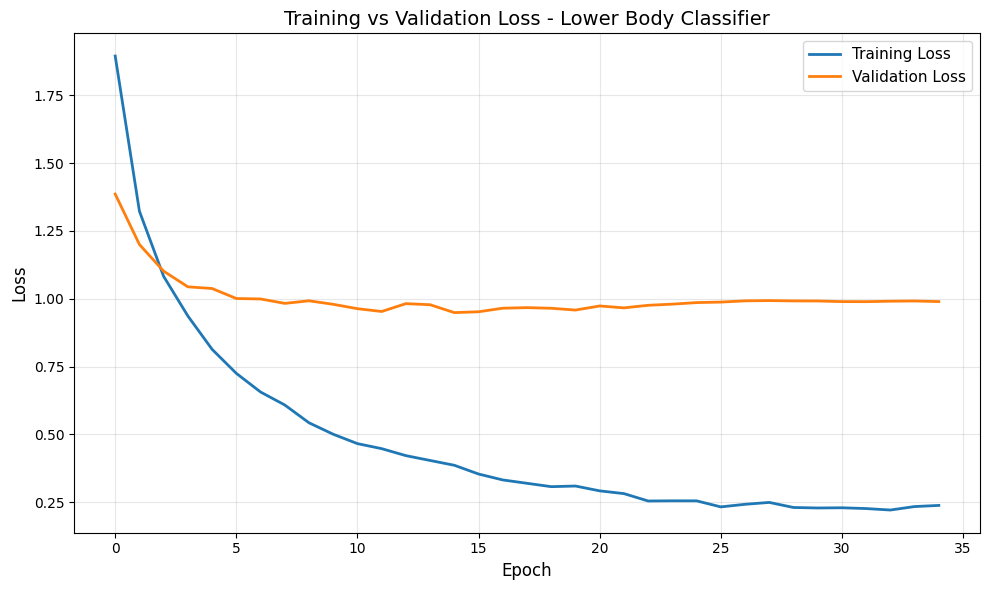

✅ Loss plot displayed


In [44]:
# Cell 12: Plot training history - Loss

print("📊 Generating loss plot...\n")  # Progress print

plt.figure(figsize=(10, 6))  # Create figure
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)  # Plot training loss
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)  # Plot validation loss
plt.xlabel("Epoch", fontsize=12)  # X label
plt.ylabel("Loss", fontsize=12)  # Y label
plt.title("Training vs Validation Loss - Lower Body Classifier", fontsize=14)  # Title
plt.legend(fontsize=11)  # Legend
plt.grid(True, alpha=0.3)  # Grid
plt.tight_layout()  # Layout
plt.show()  # Show plot

print("✅ Loss plot displayed")  # Done message


📊 Generating accuracy plot...



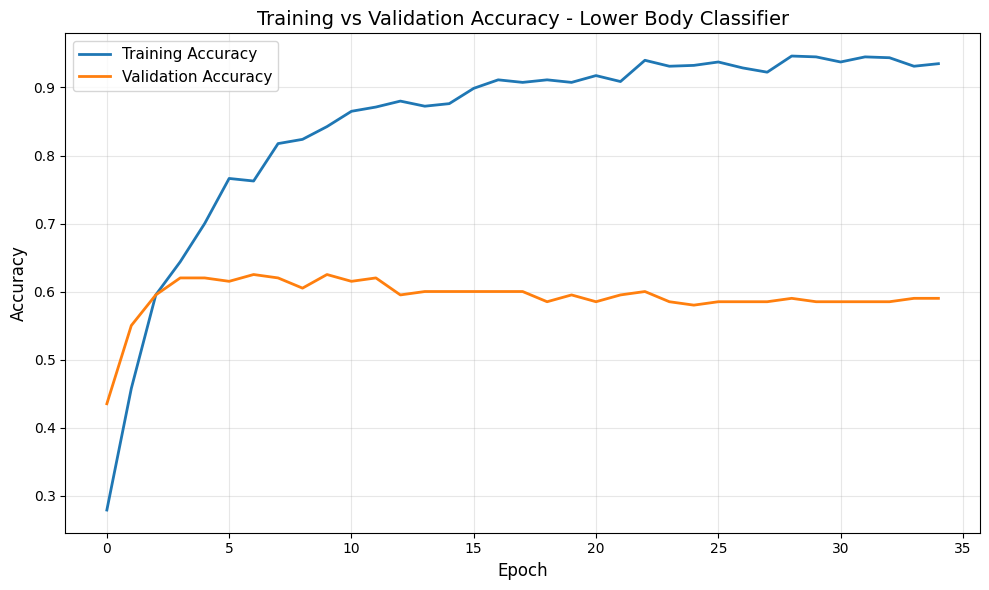

✅ Accuracy plot displayed


In [45]:
# Cell 13: Plot training history - Accuracy

print("📊 Generating accuracy plot...\n")  # Progress print

plt.figure(figsize=(10, 6))  # Create figure
plt.plot(history.history["accuracy"], label="Training Accuracy", linewidth=2)  # Plot training accuracy
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2)  # Plot validation accuracy
plt.xlabel("Epoch", fontsize=12)  # X label
plt.ylabel("Accuracy", fontsize=12)  # Y label
plt.title("Training vs Validation Accuracy - Lower Body Classifier", fontsize=14)  # Title
plt.legend(fontsize=11)  # Legend
plt.grid(True, alpha=0.3)  # Grid
plt.tight_layout()  # Layout
plt.show()  # Show plot

print("✅ Accuracy plot displayed")  # Done message


In [46]:
# Cell 14: Display final training results

print("\n" + "=" * 60)  # Divider
print("📊 FINAL TRAINING RESULTS (LOWER BODY)")  # Heading
print("=" * 60 + "\n")  # Divider

final_train_loss = history.history["loss"][-1]  # Last training loss
final_train_acc = history.history["accuracy"][-1]  # Last training accuracy
final_val_loss = history.history["val_loss"][-1]  # Last validation loss
final_val_acc = history.history["val_accuracy"][-1]  # Last validation accuracy

best_val_acc = max(history.history["val_accuracy"])  # Best validation accuracy
best_epoch = history.history["val_accuracy"].index(best_val_acc) + 1  # Epoch of best val accuracy

print(f"Final Training Loss:        {final_train_loss:.4f}")  # Print train loss
print(f"Final Training Accuracy:    {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")  # Print train acc

print(f"\nFinal Validation Loss:      {final_val_loss:.4f}")  # Print val loss
print(f"Final Validation Accuracy:  {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")  # Print val acc

print(f"\nBest Validation Accuracy:   {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")  # Print best val acc
print(f"Best Epoch:                 {best_epoch}")  # Print best epoch

print(f"\nTotal Epochs Trained:       {len(history.history['loss'])}")  # Print epoch count
print(f"\nModel saved as:             {model_filename}")  # Print model file name

print("\n" + "=" * 60)  # Divider
print("🎉 LOWER BODY CLASSIFICATION MODEL TRAINING COMPLETE!")  # Final message
print("=" * 60)  # Divider



📊 FINAL TRAINING RESULTS (LOWER BODY)

Final Training Loss:        0.2381
Final Training Accuracy:    0.9350 (93.50%)

Final Validation Loss:      0.9896
Final Validation Accuracy:  0.5900 (59.00%)

Best Validation Accuracy:   0.6250 (62.50%)
Best Epoch:                 7

Total Epochs Trained:       35

Model saved as:             lower_body_mobilenetv2.h5

🎉 LOWER BODY CLASSIFICATION MODEL TRAINING COMPLETE!
